In [153]:
import pandas as pd
import numpy as np
import seaborn as sns

pd.set_option('display.width', 10000)
pd.set_option('display.max_columns', 10000)
import warnings
warnings.filterwarnings('ignore')

In [154]:
# Import East Palo Alto
epa = pd.read_csv('epa.csv')

# ImportParcelID is more accurate than APN
epa = epa.groupby('ImportParcelID', as_index = False).first()
print(epa.shape)
epa.head(1)

(4812, 30)


,ImportParcelID,RowID,AssessorParcelNumber,PropertyFullStreetAddress,PropertyCity,PropertyState,PropertyZip,PropertyAddressLatitude,PropertyAddressLongitude,FIPS,PropertyZoningSourceCode,LotSizeSquareFeet,LotSizeAcres,RowID:1,PropertyCountyLandUseCode,PropertyLandUseStndCode,OccupancyStatusStndCode,YearBuilt,NoOfStories,NoOfUnits,TotalRooms,TotalBedrooms,TotalKitchens,TotalCalculatedBathCount,TotalActualBathCount,EffectiveYearBuilt,YearRemodeled,BuildingConditionStndCode,BuildingQualityStndCode,SewerStndCode
0,19367983,AA226290-28D5-E511-80C1-3863BB43AC67,036-032-090,2717 GONZAGA ST,EAST PALO ALTO,CA,94303.0,37.478453,-122.135073,6081,NaN,2900.0,0.066,AA226290-28D5-E511-80C1-3863BB43AC67,NaN,RR101,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [155]:
# Load CHPC which will help determine if property is subsidized
chpc = pd.read_excel('chpc.xls', sheet_name='Cleaned')

chpc.head(1)

,DataSet,Property Name,Address_Cleaned,Units with Assistance (Inclusive of All Programs),Units with Rental Assistance (HUD and/or mfhd),HUD Program?,Application Number (TCAC),Type of Tax Credit (TCAC),Application Stage (TCAC),Placed in Service (PIS) Date (TCAC),Construction Type (TCAC),Housing Type (TCAC),Low Income Units (TCAC),Number of SRO/Studio Units,Number of 1 Bedroom Units,Number of 2 Bedroom Units,Number of 3 Bedroom Units,Number of 4 Bedroom Units,Number of 5 Bedroom Units,Number of 6 Bedroom Units,Units at or below 30% AMI,Units at 35% AMI,Units at 40% AMI,Units at 45% AMI,Units at 50% AMI,Units at 55% AMI,Units at 60% AMI,General Partner (1),Management Company,Developer,Borrower+Project ID (mfhd),Tax_Credit_Indicator (mfhd),Date_Tax_Credit_Expires (mfhd),Date_Of_Operation (mfhd),Date_Restrictive_Clause_Expires (mfhd),Notes,Combined Multiple Sites?,LatLong_Google,Latitude,Longitude,Unique: Property Name_CleanedAddress-,GEOID (from Geocode of Lat/Long),TRACTCE (from Geocode of Lat/Long),Within Half Mile of HQT?
0,"HUD, TCAC",COMM22 Senior Housing,"690 Beardsley Street, San Diego, California, 9...",69.0,NaN,NaN,CA-2013-852,0.04,Preliminary Reservation,2015,New Construction,Seniors,69.0,15.0,51.0,4.0,0.0,0.0,0.0,0.0,15.0,0.0,12.0,0.0,42.0,0.0,0.0,"COMM22 Senior GP, LLC",BRIDGE Property Management Company,BRIDGE Housing Corporation,NaN,NaN,NaN,NaN,NaN,HUD has 30 units,NaN,"32.7045781,-117.1444356",32.704578,-117.144436,"COMM22 Senior Housing690 Beardsley Street, San...",6.073005e+09,4900.0,1.0


In [156]:
# Cleaning so that we can properly join Ztrax and CHPC data
chpc['Address_Num'] = chpc['Address_Cleaned'].str.extract(r'(\d+)')
chpc['Address_Name'] = chpc['Address_Cleaned'].str.extract(r'([^\d,-]\w+)')
chpc['Address_Name'] = chpc['Address_Name'].str.upper()
chpc.head(3)

,DataSet,Property Name,Address_Cleaned,Units with Assistance (Inclusive of All Programs),Units with Rental Assistance (HUD and/or mfhd),HUD Program?,Application Number (TCAC),Type of Tax Credit (TCAC),Application Stage (TCAC),Placed in Service (PIS) Date (TCAC),Construction Type (TCAC),Housing Type (TCAC),Low Income Units (TCAC),Number of SRO/Studio Units,Number of 1 Bedroom Units,Number of 2 Bedroom Units,Number of 3 Bedroom Units,Number of 4 Bedroom Units,Number of 5 Bedroom Units,Number of 6 Bedroom Units,Units at or below 30% AMI,Units at 35% AMI,Units at 40% AMI,Units at 45% AMI,Units at 50% AMI,Units at 55% AMI,Units at 60% AMI,General Partner (1),Management Company,Developer,Borrower+Project ID (mfhd),Tax_Credit_Indicator (mfhd),Date_Tax_Credit_Expires (mfhd),Date_Of_Operation (mfhd),Date_Restrictive_Clause_Expires (mfhd),Notes,Combined Multiple Sites?,LatLong_Google,Latitude,Longitude,Unique: Property Name_CleanedAddress-,GEOID (from Geocode of Lat/Long),TRACTCE (from Geocode of Lat/Long),Within Half Mile of HQT?,Address_Num,Address_Name
0,"HUD, TCAC",COMM22 Senior Housing,"690 Beardsley Street, San Diego, California, 9...",69.0,NaN,NaN,CA-2013-852,0.04,Preliminary Reservation,2015,New Construction,Seniors,69.0,15.0,51.0,4.0,0.0,0.0,0.0,0.0,15.0,0.0,12.0,0.0,42.0,0.0,0.0,"COMM22 Senior GP, LLC",BRIDGE Property Management Company,BRIDGE Housing Corporation,NaN,NaN,NaN,NaN,NaN,HUD has 30 units,NaN,"32.7045781,-117.1444356",32.704578,-117.144436,"COMM22 Senior Housing690 Beardsley Street, San...",6.073005e+09,4900.0,1.0,690,BEARDSLEY
1,"HUD, TCAC",Valencia 9 Apartments,"Valencia Avenue and E. 9th Street, San Bernard...",75.0,NaN,NaN,CA-2014-162,0.09,Preliminary Reservation,2015-05-15 00:00:00,New Construction,Large Family,75.0,0.0,10.0,40.0,22.0,4.0,0.0,0.0,8.0,0.0,0.0,34.0,15.0,0.0,18.0,Southern California Housing Development Corpor...,National Community Renaissance,National Community Renaissance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"34.1157958,-117.2717424",34.115796,-117.271742,Valencia 9 ApartmentsValencia Avenue and E. 9t...,6.071006e+09,6401.0,0.0,9,VALENCIA
2,"HUD, TCAC",Mercy Arc Housing,"1500 Page Street, San Francisco, California, 9...",16.0,15.0,NaN,CA-2014-165,0.09,Preliminary Reservation,2017-03-23 00:00:00,New Construction,Special Needs,16.0,16.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,7.0,2.0,0.0,1.0,Mercy Housing California Special Needs,Mercy Housing Management Group,Mercy Housing California,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"37.7712566,-122.4458935",37.771257,-122.445893,"Mercy Arc Housing 1500 Page Street, San Franci...",6.075017e+09,16600.0,1.0,1500,PAGE


In [157]:
# Cleaning again
epa['Address_Num'] = epa['PropertyFullStreetAddress'].str.extract(r'(\d+)')
epa['Address_Name'] = epa['PropertyFullStreetAddress'].str.extract(r'([^\d,-]\w+)')
epa['Address_Name'] = epa['Address_Name'].str.upper()
epa.head(3)

,ImportParcelID,RowID,AssessorParcelNumber,PropertyFullStreetAddress,PropertyCity,PropertyState,PropertyZip,PropertyAddressLatitude,PropertyAddressLongitude,FIPS,PropertyZoningSourceCode,LotSizeSquareFeet,LotSizeAcres,RowID:1,PropertyCountyLandUseCode,PropertyLandUseStndCode,OccupancyStatusStndCode,YearBuilt,NoOfStories,NoOfUnits,TotalRooms,TotalBedrooms,TotalKitchens,TotalCalculatedBathCount,TotalActualBathCount,EffectiveYearBuilt,YearRemodeled,BuildingConditionStndCode,BuildingQualityStndCode,SewerStndCode,Address_Num,Address_Name
0,19367983,AA226290-28D5-E511-80C1-3863BB43AC67,036-032-090,2717 GONZAGA ST,EAST PALO ALTO,CA,94303.0,37.478453,-122.135073,6081,NaN,2900.0,0.066,AA226290-28D5-E511-80C1-3863BB43AC67,NaN,RR101,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2717,GONZAGA
1,19428316,D7961991-28D5-E511-80C1-3863BB43AC67,062-111-020,915 ALBERNI ST,EAST PALO ALTO,CA,94303.0,37.474324,-122.152222,6081,NaN,7257.0,0.166,D7961991-28D5-E511-80C1-3863BB43AC67,1.0,RR101,O,1955.0,NaN,0.0,6.0,3.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,915,ALBERNI
2,19428317,D8961991-28D5-E511-80C1-3863BB43AC67,062-111-030,923 ALBERNI ST,EAST PALO ALTO,CA,94303.0,37.474295,-122.152021,6081,NaN,7257.0,0.166,D8961991-28D5-E511-80C1-3863BB43AC67,1.0,RR101,O,1950.0,NaN,0.0,6.0,3.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,923,ALBERNI


In [158]:
# Merge based on euclidean distance
chpc = chpc.dropna(subset=['Longitude', 'Latitude'])
def merge_euclidean(table, chpc, eps=0.001):
    chpc_list = []
    table['merge_row'] = table.index.values
    for i, row in table.iterrows():
        chpc_subset = chpc.loc[((chpc.Longitude - row.PropertyAddressLongitude)**2 + (chpc.Latitude - row.PropertyAddressLatitude)**2 < eps) & (chpc.Address_Num == row.Address_Num) & (chpc.Address_Name == row.Address_Name)]
        chpc_subset['merge_row'] = i
        chpc_list.append(chpc_subset)
    chpc_found = pd.concat(chpc_list)

    result = pd.merge(table, chpc_found, on='merge_row', how='inner')
    return result

t = merge_euclidean(epa, chpc)

In [159]:
# These were the matches so attach 'Y' for subsidized
t['Subsidized'] = 'Y'
t.head(2)

,ImportParcelID,RowID,AssessorParcelNumber,PropertyFullStreetAddress,PropertyCity,PropertyState,PropertyZip,PropertyAddressLatitude,PropertyAddressLongitude,FIPS,PropertyZoningSourceCode,LotSizeSquareFeet,LotSizeAcres,RowID:1,PropertyCountyLandUseCode,PropertyLandUseStndCode,OccupancyStatusStndCode,YearBuilt,NoOfStories,NoOfUnits,TotalRooms,TotalBedrooms,TotalKitchens,TotalCalculatedBathCount,TotalActualBathCount,EffectiveYearBuilt,YearRemodeled,BuildingConditionStndCode,BuildingQualityStndCode,SewerStndCode,Address_Num_x,Address_Name_x,merge_row,DataSet,Property Name,Address_Cleaned,Units with Assistance (Inclusive of All Programs),Units with Rental Assistance (HUD and/or mfhd),HUD Program?,Application Number (TCAC),Type of Tax Credit (TCAC),Application Stage (TCAC),Placed in Service (PIS) Date (TCAC),Construction Type (TCAC),Housing Type (TCAC),Low Income Units (TCAC),Number of SRO/Studio Units,Number of 1 Bedroom Units,Number of 2 Bedroom Units,Number of 3 Bedroom Units,Number of 4 Bedroom Units,Number of 5 Bedroom Units,Number of 6 Bedroom Units,Units at or below 30% AMI,Units at 35% AMI,Units at 40% AMI,Units at 45% AMI,Units at 50% AMI,Units at 55% AMI,Units at 60% AMI,General Partner (1),Management Company,Developer,Borrower+Project ID (mfhd),Tax_Credit_Indicator (mfhd),Date_Tax_Credit_Expires (mfhd),Date_Of_Operation (mfhd),Date_Restrictive_Clause_Expires (mfhd),Notes,Combined Multiple Sites?,LatLong_Google,Latitude,Longitude,Unique: Property Name_CleanedAddress-,GEOID (from Geocode of Lat/Long),TRACTCE (from Geocode of Lat/Long),Within Half Mile of HQT?,Address_Num_y,Address_Name_y,Subsidized
0,19431645,72A31991-28D5-E511-80C1-3863BB43AC67,063-103-440,2400 GLORIA WAY,EAST PALO ALTO,CA,94303.0,37.472012,-122.140122,6081,NaN,87556.0,2.01,72A31991-28D5-E511-80C1-3863BB43AC67,5.0,RI104,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2400,GLORIA,1166,TCAC,Gloria Way Community Housing,"2400 Gloria Way, East Palo Alto, California, 9...",37.0,NaN,NaN,CA-1995-054,0.09,Extended,1996-02-29 00:00:00,New Construction,Large Family,37.0,0.0,0.0,20.0,10.0,8.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MP CAN DO, Inc.",MidPen Housing Corporation,MidPen Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"37.471951,-122.141198",37.471951,-122.141198,"Gloria Way Community Housing2400 Gloria Way, E...",6.081612e+09,611800.0,0.0,2400,GLORIA,Y
1,19432518,9BA61991-28D5-E511-80C1-3863BB43AC67,063-202-280,2361 UNIVERSITY AVE,EAST PALO ALTO,CA,94303.0,37.470258,-122.139775,6081,NaN,44254.0,1.02,9BA61991-28D5-E511-80C1-3863BB43AC67,5.0,RI104,NaN,2004.0,3.0,14.0,11.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2361,UNIVERSITY,1966,TCAC,Nugent Square,"2361 University Avenue, East Palo Alto, Califo...",31.0,NaN,NaN,CA-2002-056,0.09,Placed In Service,2004-12-02 00:00:00,New Construction,Large Family,31.0,0.0,0.0,14.0,18.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Nugent Square, Inc.","Eden Housing Management, Inc",EPA CAN DO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"37.4704163,-122.1406864",37.470416,-122.140686,"Nugent Square2361 University Avenue, East Palo...",6.081612e+09,612000.0,0.0,2361,UNIVERSITY,Y


In [160]:
# Rejoin with original epa table to identify subsidized units
t = t[['ImportParcelID', 'Subsidized']]
epa = pd.merge(epa, t, on='ImportParcelID', how='left')
epa.fillna(value={'Subsidized': 'N'}, inplace=True)
epa.head()

,ImportParcelID,RowID,AssessorParcelNumber,PropertyFullStreetAddress,PropertyCity,PropertyState,PropertyZip,PropertyAddressLatitude,PropertyAddressLongitude,FIPS,PropertyZoningSourceCode,LotSizeSquareFeet,LotSizeAcres,RowID:1,PropertyCountyLandUseCode,PropertyLandUseStndCode,OccupancyStatusStndCode,YearBuilt,NoOfStories,NoOfUnits,TotalRooms,TotalBedrooms,TotalKitchens,TotalCalculatedBathCount,TotalActualBathCount,EffectiveYearBuilt,YearRemodeled,BuildingConditionStndCode,BuildingQualityStndCode,SewerStndCode,Address_Num,Address_Name,merge_row,Subsidized
0,19367983,AA226290-28D5-E511-80C1-3863BB43AC67,036-032-090,2717 GONZAGA ST,EAST PALO ALTO,CA,94303.0,37.478453,-122.135073,6081,NaN,2900.0,0.066,AA226290-28D5-E511-80C1-3863BB43AC67,NaN,RR101,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2717,GONZAGA,0,N
1,19428316,D7961991-28D5-E511-80C1-3863BB43AC67,062-111-020,915 ALBERNI ST,EAST PALO ALTO,CA,94303.0,37.474324,-122.152222,6081,NaN,7257.0,0.166,D7961991-28D5-E511-80C1-3863BB43AC67,1.0,RR101,O,1955.0,NaN,0.0,6.0,3.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,915,ALBERNI,1,N
2,19428317,D8961991-28D5-E511-80C1-3863BB43AC67,062-111-030,923 ALBERNI ST,EAST PALO ALTO,CA,94303.0,37.474295,-122.152021,6081,NaN,7257.0,0.166,D8961991-28D5-E511-80C1-3863BB43AC67,1.0,RR101,O,1950.0,NaN,0.0,6.0,3.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,923,ALBERNI,2,N
3,19428318,D9961991-28D5-E511-80C1-3863BB43AC67,062-112-010,1304 SARATOGA AVE,EAST PALO ALTO,CA,94303.0,37.474241,-122.151642,6081,NaN,7257.0,0.166,D9961991-28D5-E511-80C1-3863BB43AC67,1.0,RR101,O,1944.0,NaN,0.0,6.0,3.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1304,SARATOGA,3,N
4,19428319,DA961991-28D5-E511-80C1-3863BB43AC67,062-112-020,939 ALBERNI ST,EAST PALO ALTO,CA,94303.0,37.474215,-122.151433,6081,NaN,7257.0,0.166,DA961991-28D5-E511-80C1-3863BB43AC67,1.0,RR101,O,1947.0,1.0,0.0,5.0,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,939,ALBERNI,4,N


In [161]:
# Drop subsidized units
epa = epa[epa['Subsidized'] == 'N']
epa.shape

(4805, 34)

count     1000.000000
mean     19011.853000
std       1012.317832
min      15730.000000
25%      18342.250000
50%      18965.000000
75%      19697.500000
max      22842.000000
dtype: object

Text(0.5,1,'Raw')

16.67% current number: 19017.0
33.33% current number: 19017.0
66.67% current number: 19017.0
83.33% current number: 19033.0
100.0% current number: 23060.0


count     1000.000000
mean     23101.149000
std        993.070515
min      19930.000000
25%      22407.000000
50%      23101.500000
75%      23783.000000
max      26298.000000
dtype: object

Text(0.5,1,'Cleaned')

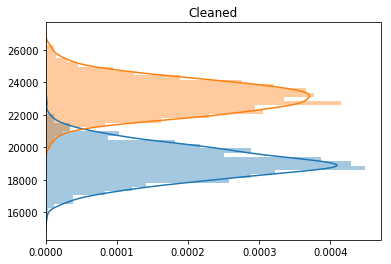

In [162]:
def mend_units(df, fix):
    # Visualizations
    np.random.seed(707)
    res = pd.Series([
        df['NoOfUnits'].sample(len(df), replace = True).sum() 
        for _ in range(1000)
    ])
    display(res.describe().apply(lambda x: format(x, 'f')))
    display(sns.distplot(res, vertical = True).set_title('Raw'))
    def clean_units(df):
        import numpy as np
        import pandas as pd
        data_dict = pd.read_excel('ZAsmt_DataDictionary_2016-01.xlsx', sheet_name='LandUse', header=5, usecols=np.arange(4))
        residential = data_dict[data_dict['Prefix Code Classification'].isin(['RI', 'RR'])]
        R = residential['StndCode']
        progress = np.linspace(0, 100, 7)[1:]
        print(str(round(progress[0], 2))+'%', 'current number:', df.NoOfUnits.sum())
        # Include only Residentials
        df = df[df['PropertyLandUseStndCode'].isin(R)]
        print(str(round(progress[1], 2))+'%', 'current number:', df.NoOfUnits.sum())
        medians = df.groupby('PropertyLandUseStndCode')['NoOfUnits'].median()
        import math
        if fix:
            def fix_units(r):
                code = r['PropertyLandUseStndCode']
                units = r['NoOfUnits']
                # return median if 0 or NaN
                #if median:
                    #if units == 0.0 or math.isnan(units):
                        #return medians[code]
                    #elif code == 'RI104' and units < 5.0:
                        #return medians[code]
                    #elif code == 'RI105' and units < 100.0:
                        #return medians[code]
                    #elif code == 'RI106' and units < 5.0:
                        #return medians[code]
                if code == 'RI101': # duplex
                    return 2.0
                elif code == 'RI102': # triplex
                    return 3.0
                elif code == 'RI103': # quad
                    return 4.0

                return r['NoOfUnits']
            # Fix duplex, tri, quad, etc
            df['NoOfUnits'] = df.apply(fix_units, axis=1)
        print(str(round(progress[3], 2))+'%', 'current number:', df.NoOfUnits.sum())
        # Fill nans with 1 for now
        value = {'NoOfUnits': 1}
        df.fillna(value=value, inplace=True)
        print(str(round(progress[4], 2))+'%', 'current number:', df.NoOfUnits.sum())
        # Fill 0's with 1 for now
        df = df.replace({'NoOfUnits': {0: 1}}) 
        print(str(round(progress[5], 2))+'%', 'current number:', df.NoOfUnits.sum())
        return df
    df = clean_units(df)
    #df = df[pd.notnull(df['EffectiveYearBuilt'])]
    # Visualizations
    np.random.seed(707)
    res2 = pd.Series([
        df['NoOfUnits'].sample(len(df), replace = True).sum() 
        for _ in range(1000)
    ])
    display(res2.describe().apply(lambda x: format(x, 'f')))
    display(sns.distplot(res2, vertical = True).set_title('Cleaned'))
    return df

# Only includes residential units
epa = mend_units(epa, fix = False)

# Round 1 (without cleaning)

In [163]:
# Clean and filter for East Palo Alto JCE only

# Only filtering possible was non-residential units
epa_jc = epa[epa['PropertyCity'] == 'EAST PALO ALTO']
print('Final number:', epa_jc.NoOfUnits.sum())

Final number: 23060.0


In [164]:
# Clean and filter for East Palo Alto Rent Control only
epa_rc = epa[epa['PropertyCity'] == 'EAST PALO ALTO']
print('Current number:', epa_rc.NoOfUnits.sum())

Current number: 23060.0


In [165]:
# Units that are exempt from RC: Single Family homes,
# condos, nursing facilities, hotels, owner-occupied duplexes and triplexes
epa_rc = epa_rc[~epa_rc['PropertyLandUseStndCode'].isin(['RR101', 'RR999', 'RR106', 'RI114'])]
print('Current number:', epa_rc.NoOfUnits.sum())

Current number: 2687.0


In [166]:
# Owner-occupied duplexes
epa_rc = epa_rc[~((epa_rc['OccupancyStatusStndCode'].isin(['O', 'I'])) & (epa_rc['PropertyLandUseStndCode'] == 'RI101'))]
print('Current number:', epa_rc.NoOfUnits.sum())

Current number: 2590.0


In [167]:
# Owner-occupied triplexes
epa_rc = epa_rc[~((epa_rc['OccupancyStatusStndCode'].isin(['O', 'I'])) & (epa_rc['PropertyLandUseStndCode'] == 'RI102'))]
print('Current number:', epa_rc.NoOfUnits.sum())

Current number: 2587.0


In [168]:
# Appropriate units LandUseCodes
# Excludes Frats, dorms, and mobile homes
r = ['RI000', 'RI101','RI102', 'RI103', 'RI104', 'RI105', 'RI106', 'RI107', 'RI108', 'RI110' 'RI112']
epa_rc = epa_rc[epa_rc['PropertyLandUseStndCode'].isin(r)]

round_1 = epa_rc.NoOfUnits.sum()
print('Final number:', round_1)

Final number: 2505.0


# Round 2 (with NoOfUnits cleaning)

In [169]:
# Import East Palo Alto
epa = pd.read_csv('epa.csv')

# ImportParcelID is more accurate than APN
epa = epa.groupby('ImportParcelID', as_index = False).first()
print(epa.shape)
#epa.head(1)

# Load CHPC which will help determine if property is subsidized
chpc = pd.read_excel('chpc.xls', sheet_name='Cleaned')

#chpc.head(1)

# Cleaning so that we can properly join Ztrax and CHPC data
chpc['Address_Num'] = chpc['Address_Cleaned'].str.extract(r'(\d+)')
chpc['Address_Name'] = chpc['Address_Cleaned'].str.extract(r'([^\d,-]\w+)')
chpc['Address_Name'] = chpc['Address_Name'].str.upper()
#Echpc.head(3)

# Cleaning again
epa['Address_Num'] = epa['PropertyFullStreetAddress'].str.extract(r'(\d+)')
epa['Address_Name'] = epa['PropertyFullStreetAddress'].str.extract(r'([^\d,-]\w+)')
epa['Address_Name'] = epa['Address_Name'].str.upper()
#.head(3)

# Merge based on euclidean distance
chpc = chpc.dropna(subset=['Longitude', 'Latitude'])
def merge_euclidean(table, chpc, eps=0.001):
    chpc_list = []
    table['merge_row'] = table.index.values
    for i, row in table.iterrows():
        chpc_subset = chpc.loc[((chpc.Longitude - row.PropertyAddressLongitude)**2 + (chpc.Latitude - row.PropertyAddressLatitude)**2 < eps) & (chpc.Address_Num == row.Address_Num) & (chpc.Address_Name == row.Address_Name)]
        chpc_subset['merge_row'] = i
        chpc_list.append(chpc_subset)
    chpc_found = pd.concat(chpc_list)

    result = pd.merge(table, chpc_found, on='merge_row', how='inner')
    return result

t = merge_euclidean(epa, chpc)

# These were the matches so attach 'Y' for subsidized
t['Subsidized'] = 'Y'
t.head(2)

# Rejoin with original epa table to identify subsidized units
t = t[['ImportParcelID', 'Subsidized']]
epa = pd.merge(epa, t, on='ImportParcelID', how='left')
epa.fillna(value={'Subsidized': 'N'}, inplace=True)
#epa.head()

# Drop subsidized units
epa = epa[epa['Subsidized'] == 'N']

(4812, 30)


count     1000.000000
mean     19011.853000
std       1012.317832
min      15730.000000
25%      18342.250000
50%      18965.000000
75%      19697.500000
max      22842.000000
dtype: object

Text(0.5,1,'Raw')

16.67% current number: 19017.0
33.33% current number: 19017.0
66.67% current number: 19034.0
83.33% current number: 19050.0
100.0% current number: 23050.0


count     1000.000000
mean     23091.501000
std        993.051914
min      19900.000000
25%      22396.250000
50%      23091.000000
75%      23767.750000
max      26293.000000
dtype: object

Text(0.5,1,'Cleaned')

Final number: 23050.0
Current number: 23050.0
Current number: 2677.0
Current number: 2559.0
Current number: 2556.0
Final number: 2474.0


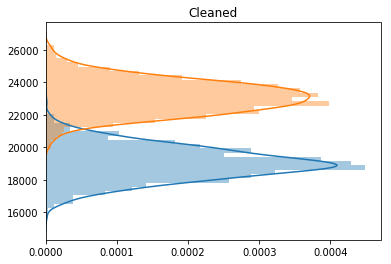

In [170]:
# Only includes residential units
epa = mend_units(epa, fix = True)


# Clean and filter for East Palo Alto JCE only

# Only filtering possible was non-residential units
epa_jc = epa[epa['PropertyCity'] == 'EAST PALO ALTO']
print('Final number:', epa_jc.NoOfUnits.sum())

# Clean and filter for East Palo Alto Rent Control only
epa_rc = epa[epa['PropertyCity'] == 'EAST PALO ALTO']
print('Current number:', epa_rc.NoOfUnits.sum())

# Units that are exempt from RC: Single Family homes,
# condos, nursing facilities, hotels, owner-occupied duplexes and triplexes
epa_rc = epa_rc[~epa_rc['PropertyLandUseStndCode'].isin(['RR101', 'RR999', 'RR106', 'RI114'])]
print('Current number:', epa_rc.NoOfUnits.sum())

# Owner-occupied duplexes
epa_rc = epa_rc[~((epa_rc['OccupancyStatusStndCode'].isin(['O', 'I'])) & (epa_rc['PropertyLandUseStndCode'] == 'RI101'))]
print('Current number:', epa_rc.NoOfUnits.sum())

# Owner-occupied triplexes
epa_rc = epa_rc[~((epa_rc['OccupancyStatusStndCode'].isin(['O', 'I'])) & (epa_rc['PropertyLandUseStndCode'] == 'RI102'))]
print('Current number:', epa_rc.NoOfUnits.sum())

# Appropriate units LandUseCodes
# Excludes Frats, dorms, and mobile homes
r = ['RI000', 'RI101','RI102', 'RI103', 'RI104', 'RI105', 'RI106', 'RI107', 'RI108', 'RI110' 'RI112']
epa_rc = epa_rc[epa_rc['PropertyLandUseStndCode'].isin(r)]

round_2 = epa_rc.NoOfUnits.sum()
print('Final number:', round_2)

In [171]:
# Difference between the rounds
# Both rounds are close to the actual 2500 units
err_round_1 = abs(2500 - round_1)
err_round_2 = abs(2500 - round_2)
print("Round 1 error:", err_round_1, "\nRound 2 error:", err_round_2)

Round 1 error: 5.0 
Round 2 error: 26.0
